# Mask R-CNN Demo & save results - Building Footprint Trial CrowdAI Weights

Trial of crowdai weights on building footprint - notebook based on mask r-cnn demo notebook
https://github.com/crowdAI/crowdai-mapping-challenge-mask-rcnn

This notebook is to make predictions and save the results afterwards

In [19]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

import glob
import tqdm

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
print(ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
#import coco
from samples.coco import coco

from coco import mask as maskUtils

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# remove coco model path
# # Local path to trained weights file
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# # Download COCO trained weights from Releases if needed
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)

PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"weights/crowdai_baseline_pretrained_weights.h5")



# original test images
img_path = "../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/"
#print(os.listdir(ROOT_DIR + "/../../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/"))
# Bristol test images
#img_path = "data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/"


# Directory of images to run detection on
#IMAGE_DIR = os.path.join(ROOT_DIR, "images") #Mask_RCNN demo images
IMAGE_DIR = os.path.join(ROOT_DIR, img_path)

/home/ot19968/Projects/Mask_RCNN


ImportError: cannot import name 'mask'

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# Load weights trained on MS-COCO
model.load_weights(model_path, by_name=True)

## crowdai Class Names


In [4]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building

## Run Object Detection

Processing 1 images
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


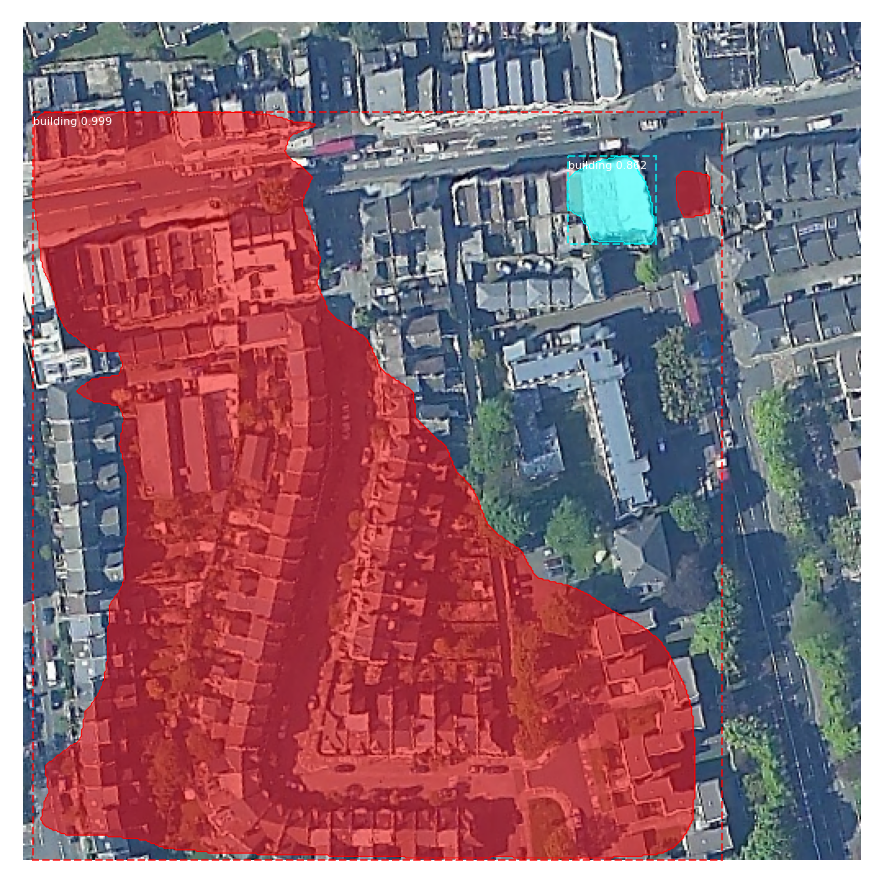

In [5]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)), plugin="tifffile")
# skimage.io.imshow(image)
# plt.show()
image_without_alpha = image[:,:,:3]
# skimage.io.imshow(image_without_alpha)
# plt.show()

# # Run detection
# results = model.detect([image], verbose=1)

# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])

# Run detection
results = model.detect([image_without_alpha], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image_without_alpha, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

# Run predictions on all the images in the test set

Note that this step might take some time depending on the GPU(s) you have and your system configuration. On a single NVIDIA TitanX it take about 1.25 hours to generate all the predictions.

In [9]:
# Gather all JPG files in the test set as small batches
files = glob.glob(os.path.join(IMAGE_DIR, "*.tif"))
ALL_FILES=[]
_buffer = []
for _idx, _file in enumerate(files):
    if len(_buffer) == config.IMAGES_PER_GPU * config.GPU_COUNT:
        ALL_FILES.append(_buffer)
        _buffer = []
    else:
        _buffer.append(_file)

if len(_buffer) > 0:
    ALL_FILES.append(_buffer)
    
print(ALL_FILES[:5])

[['/home/ot19968/Projects/Mask_RCNN/../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/Ortho_RGB_P00012380_20070825_20081018_40cm_res.0.tif'], ['/home/ot19968/Projects/Mask_RCNN/../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/Ortho_RGB_P00012380_20070825_20081018_40cm_res.10.tif'], ['/home/ot19968/Projects/Mask_RCNN/../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/Ortho_RGB_P00012380_20070825_20081018_40cm_res.12.tif'], ['/home/ot19968/Projects/Mask_RCNN/../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/Ortho_RGB_P00012380_20070825_20081018_40cm_res.14.tif'], ['/home/ot19968/Projects/Mask_RCNN/../../data/Environment_Agency/Vertical_Photography/512/P_4641/Ortho_RGB_P00012380_20070825_20081018_40cm_res/Ortho_RGB_P00012380_20070825_20081018_40cm_res.16.ti

In [17]:
# Iterate over all the batches and predict
_final_object = []
for files in tqdm.tqdm(ALL_FILES):
    images = [skimage.io.imread(x)[:,:,:3] for x in files]
    images = [x[:,:,:3] for x in images]
    predictions = model.detect(images, verbose=0)
    for _idx, r in enumerate(predictions):
        _file = files[_idx]
        image_id = int(_file.split("res.")[-1].replace(".tif",""))
        for _idx, class_id in enumerate(r["class_ids"]):
            if class_id == 1:
                mask = r["masks"].astype(np.uint8)[:, :, _idx]
                bbox = np.around(r["rois"][_idx], 1)
                bbox = [float(x) for x in bbox]
                _result = {}
                _result["image_id"] = image_id
                _result["category_id"] = 100
                _result["score"] = float(r["scores"][_idx])
                _mask = maskUtils.encode(np.asfortranarray(mask))
                _mask["counts"] = _mask["counts"].decode("UTF-8")
                _result["segmentation"] = _mask
                _result["bbox"] = [bbox[1], bbox[0], bbox[3] - bbox[1], bbox[2] - bbox[0]]
                _final_object.append(_result)

  0%|          | 0/51 [00:00<?, ?it/s]


NameError: name 'maskUtils' is not defined

# Write prediction files to JSON 

In [ ]:
fp = open((os.path.join(ROOT_DIR, "/samples/building_footprint_tests/predictions.json")), "w")
import json
print("Writing JSON...")
fp.write(json.dumps(_final_object))
fp.close()